# 章節 9：二維空間

## 9.7 可靠區間（Credible Interval）

另一個視覺化後驗聯合分佈是計算可靠區間。當我們在 3.5 小節看到的可靠區間，作者有跳過一個微小的觀點：對於一個分佈存在很多相同的可靠區間。例如你要一個 50% 的可靠區間，你可以選取任何一組數值（可能不連續）它們的機率和為 50%。

當數值是一個維度，通常適用中央可靠區間；例如中央 50% 的可靠區間包含所有在第 25 分位和第 75 分位的數值。再多維空間的正確的可靠區間是不明顯的。最好是根據情境來選擇，但通常是用最大似然可靠區間（maximum likelihood credible interval），也就是包含最有可能發生的數值加總到 50%（或是其他的百分比）。

thinkbayes.Joint 提供了一個方法計算最大似然可靠區間：

<pre>
# class Joint:

def MaxLikeInterval(self, percentage=90):
    interval = []
    total = 0
    
    # 列出所有 pmf 中的數值
    t = [(prob, val) for val, prob in self.Items()]
    
    # 根據機率由大排到小
    t.sort(reverse=True)
    
    # 迭代所有的數值
    for prob, val in t:
        interval.append(val)
        total += prob
        
        # 如果超過指定的百分比就跳出迴圈
        if total >= percentage/100.0:
            break
     
    # 回傳一序列的 pmf 中的數值
    # 請注意數值不一定是連續的
    return interval
</pre>

為了視覺化區間，這邊寫了一個 MakeCrediblePlot 方法畫出 alpha, beta 不同的可靠區間重疊的情況（先將 9.6 小節的程式碼放到下格）：

In [45]:
import thinkbayes as tb
import math
import matplotlib.pyplot as plt
import numpy as np


def plot_dist(dist, c=None):
    x, y = zip(*sorted(dist.Items()))
    plt.plot(x, y, c=c)

    
# Paintball 繼承自 Suite 以及 Joint
class Paintball(tb.Suite, tb.Joint):
    
    def __init__(self, alphas, betas, locations):
        # alphas：一序列的 alpha 值
        # betas：一序列的 beta 值
        
        # 所有可能漆彈的位置；為了之後 Likelihood 方法使用
        self.locations = locations
        
        # pairs：所有 alpha, beta 的配對
        pairs = [(alpha, beta)
            for alpha in alphas
            for beta in betas
        ]
        
        tb.Suite.__init__(self, pairs)
    
    
    def Likelihood(self, data, hypo):
        # alpha, beta：假設敵人的位置
        alpha, beta = hypo

        # x：觀察到的牆面漆彈位置
        x = data
        pmf = MakeLocationPmf(alpha, beta, self.locations)

        # 從建立好的 pmf 得到漆彈位置的似然性
        like = pmf.Prob(x)
        return like
        

# 計算每個位置被漆彈打到的機率，跟掃射速度成反比
def MakeLocationPmf(alpha, beta, locations):
    # alpha, beta：敵人的座標
    # locations：一序列牆上漆彈的位置

    pmf = tb.Pmf()
    for x in locations:
        prob = 1.0 / StrafingSpeed(alpha, beta, x)
        pmf.Set(x, prob)
        
    pmf.Normalize()
    # 回傳漆彈位置與其對應的機率
    return pmf       


def StrafingSpeed(alpha, beta, x):
    # alpha, beta：敵人的座標
    # x：牆上漆彈的位置
    
    
    theta = math.atan2(x - alpha, beta)
    speed = beta / math.cos(theta)**2
    
    # 回傳 x 對 theta 的微分
    return speed

alphas = range(0, 31)
betas = range(1, 51)
locations = range(0, 31)
suite = Paintball(alphas, betas, locations)

# 根據牆上漆彈位置更新先驗分佈
suite.UpdateSet([15, 16, 18, 21])
print()

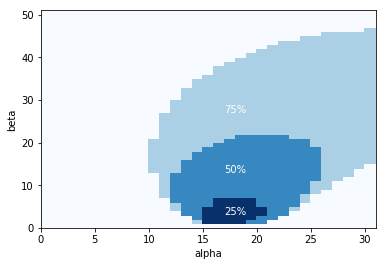

In [48]:
import numpy as np

def MakeCrediblePlot(suite):
    
    # d 是一個 dictionary 紀錄有多少的 alpha, beta 配對
    d = dict((pair, 0) for pair in suite.Values())
    percentages = [75, 50, 25]
    
    
    for p in percentages:
        interval = suite.MaxLikeInterval(p)
    
        # 將落在此區間的 alpha, beta 配對加總
        for pair in interval:
            d[pair] += 1
            
    return d


d = MakeCrediblePlot(suite)
alphas, betas = zip(*d.keys())
ci_map = np.zeros((max(betas)+1, max(alphas)+1))

for (alpha, beta), v in d.items():
    ci_map[beta, alpha] += v

plt.pcolor(ci_map, cmap='Blues')
plt.xlabel("alpha")
plt.ylabel("beta")
plt.text(17, 3, "25%", color="w")
plt.text(17, 13, "50%", color="w")
plt.text(17, 27, "75%", color="w")
plt.show()

（為了忠於作者的表達，MakeCrediblePlot 方法直接來自原作者的實作，後續的作圖才是由譯者撰寫）

上圖是可靠區間重疊的情況。敵人位置的 25% 可靠區間是最深的區域，靠近下方牆面。越高的百分比，當然可靠區間越大，並偏向體育館右方。

![場地示意圖](paintball.png)